<h1>The Politics of COVID-19 as Seen on Twitter</h1>

Group 3: Justin Deutsch, Djustin8; Emily Lawson, emily03; Matthew Pinho, mpinho16

The COVID-19 pandemic has people flooding the internet with updates, facts, and opinions but peoples opinions can differ, change over time, align with their political parties or none of the above creating a lot of confusion. Now is not the time for indecisiveness, debate, and disagreement. The economy, people’s livelihoods, and most importantly people’s lives are at stake. 

Therefore, Group 3 will evaluate, and analyze the growth over time of the political relevance of COVID-19 as well as compare and contrast the sentiments and the perspective of the major political figures on the pandemic of both major political parties.

We want to know how have sentiments changed about the pandemic crisis over time generally and party-wise? How has the vocabulary changed? How different do Democrats and Republicans think? As well as how loyal are their members to their party’s viewpoints?\

Here are a few questions we want to answer:
1. Is there any partisanship in the issue surrounding the pandemic? If so, to what degree?
2. How have the general sentiments for both parties changed over time?

Our hypothesis: We hypothesize that the sentiments will show everyone has taken it more seriously over time, but party-wise Republicans keep a more positive outlook and Democrats are more negative. We also believe that individual’s opinions will be loyal or align with their party’s.


## Collecting the Data

Our end goal is to collect all tweets on around perhaps 20 different politicians (10 from each party) from the beginning of January this year. But right we have only collected tweets from 6 politicians (3 from each party) from the beginning of March. For now, we are working with a small sample and a small time interval because we want only to test our algorithms for efficiency while also thinking about what exactly to do with our data: how we want to visualize it/present it, how (if we need to) we can change our approach, etc.

### Authorization
The authorization is basic, except we have the parameter `wait_on_rate_limit=True`, which automatically and conveniently does the process on waiting on Tweepy's API rate limits.

In [7]:
import pandas as pd
import json
from pprint import pprint
import tweepy

def loadKeys(key_file):
    with open('keys.json') as f:
        key_dict = json.load(f)
    return key_dict['api_key'], key_dict['api_secret'], key_dict['token'], key_dict['token_secret']

KEY_FILE = 'keys.json'
[api_key, api_secret, token, token_secret] = loadKeys(KEY_FILE)
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(token, token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [9]:
REP_NAMES = ['Trump','Rubio','Crenshaw','DeWine','Scott','Ernst','Barrasso','McCarthy','Pompeo','Pence']
DEM_NAMES = ['Booker','Jones','Pelosi','Sanders','Tlaib','Schumer','Warren','Harris','Cuomo','Biden']

### Defining functions for collecting data
Below, we define two functions. The second one `getTweetsSince` is the one that does the job of collecting data using Tweepy, given a Twitter username and a `since_id`, the parameter for the date after which tweets are collected. This function essentially does the same job as Tweepy's `Cursor` function, which we were trying to use initially. However, we kept running into problems using it to collect data, because the `Cursor` function somehow was completely unresponsive to the `since_id` parameter.

Other than that, our `getTweetsSince` function uses an auxiliary function, `appendTweet`, which is essentially responsible for properly appending a tweet's information we think is important (e.g., the text, post date, whether or not it is a retweet) into our data frame.

In [8]:
def hasMediaOrURLs(tweet):
    return len(tweet.entities.get('urls')) > 0 or 'media' in tweet.entities

def appendTweet(data,tweet):
    party = 'R' if any(substring in tweet.user.name for substring in REP_NAMES) else 'D'
    IS_RETWEET = hasattr(tweet, 'retweeted_status')
    if IS_RETWEET:
        text = tweet.retweeted_status.full_text
        favorites = tweet.retweeted_status.favorite_count
    else:
        text = tweet.full_text
        favorites = tweet.favorite_count
    row = [tweet.user.name,
           tweet.user.screen_name,
           party,
           text,
           tweet.created_at,
           favorites,
           tweet.retweet_count,
           IS_RETWEET,
           hasMediaOrURLs(tweet)]
    row_series = pd.Series(row, index = data.columns)
    data = data.append(row_series, ignore_index=True)
    return data

def getTweetsSince(since_id,username,data):
    page = 1
    last_page = False
    while True:
        tweets = api.user_timeline(id=username,page=page,tweet_mode='extended')
        if tweets:
            if str(tweets[-1].created_at) < since_id:
                last_page = True
            for tweet in tweets:
                if last_page and str(tweet.created_at) < since_id:
                    return data
                data = appendTweet(data,tweet)
        else:
            return data
        page += 1

### Collecting data
Now that the important functions are defined, all that is left to do is iterate over a list of politicians' Twitter usernames, and call `getTweetsSince` on each username. And this process at its conclusion produces a big data frame on all of the tweets from all of the given politicans since the given date. And the end of this entire step, the data is stored into a .csv file to be passed on for analysis.

In [ ]:
politicians = []
with open('politician_usernames', 'r') as f:
    line = f.readline()
    while line:
        politicians.append(line.strip())
        line = f.readline()

In [ ]:
data = pd.DataFrame(columns=["Name","Username","Party","Text","Created",
                                 "Favorite Count","Retweet Count","Retweet","Media Attached"])
since_id = '2020-01-01'
for username in politicians:
    data = getTweetsSince(since_id,username,data)
data.to_csv('twenty_politicians')



## Processing the Data

In this step, we put the data in the .csv file from the previous step back into a data frame.

In [10]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from itertools import groupby

### Loading Data

The data stored within the file name provided in `DATA_FILE` is read into a pandas DataFrame using the provided `read_csv` function. The data stored within the `Created` column represents the date and time at which the tweet was published. To make this information easier to work with in the future for plotting and comparisons, it is converted to a `datetime` object using pandas provided `to_datetime` function. To allow for quick reference in the future, each person's name and Twitter handled are printed in a table as well as the data's first 5 rows to view the column names and information stored in.

In [11]:
# Loading in the data from FILE
DATA_FILE = 'twenty_politicians'

In [12]:
# Reading the data 
df = pd.read_csv(DATA_FILE, index_col=0)

# Converting the data Created to a datetime object
df['Created'] = pd.to_datetime(df['Created'])

df.shape, df.dtypes

((21790, 9),
 Name                      object
 Username                  object
 Party                     object
 Text                      object
 Created           datetime64[ns]
 Favorite Count             int64
 Retweet Count              int64
 Retweet                     bool
 Media Attached              bool
 dtype: object)

In [13]:
# Displaying the list of people and their twitter handles
names_handles = zip(df['Name'].unique().tolist(), df['Username'].unique().tolist())

print(f"{'Name':>20} ---> Twitter Handle")
print('----------------------------------------')
for n, h in names_handles:
    print(f'{n:>20} ---> {h}')

                Name ---> Twitter Handle
----------------------------------------
     Donald J. Trump ---> realDonaldTrump
   Rep. Dan Crenshaw ---> RepDanCrenshaw
Governor Mike DeWine ---> GovMikeDeWine
  Sen. John Barrasso ---> SenJohnBarrasso
           Tim Scott ---> SenatorTimScott
          Joni Ernst ---> SenJoniErnst
      Kevin McCarthy ---> GOPLeader
    Secretary Pompeo ---> SecPompeo
          Mike Pence ---> Mike_Pence
         Marco Rubio ---> marcorubio
           Joe Biden ---> JoeBiden
        Andrew Cuomo ---> NYGovCuomo
      Bernie Sanders ---> BernieSanders
        Nancy Pelosi ---> SpeakerPelosi
       Chuck Schumer ---> SenSchumer
    Elizabeth Warren ---> ewarren
       Kamala Harris ---> KamalaHarris
  Senator Doug Jones ---> SenDougJones
       Rashida Tlaib ---> RashidaTlaib
         Cory Booker ---> CoryBooker


In [14]:
df.head()

,Name,Username,Party,Text,Created,Favorite Count,Retweet Count,Retweet,Media Attached
0,Donald J. Trump,realDonaldTrump,R,https://t.co/shcVSYZmuY https://t.co/ispKWWF96K,2020-04-28 20:24:20,40461,10154,False,True
1,Donald J. Trump,realDonaldTrump,R,https://t.co/9YNWvhqCk7,2020-04-28 20:14:31,28307,6971,False,True
2,Donald J. Trump,realDonaldTrump,R,LIVE: POTUS delivers remarks on supporting sma...,2020-04-28 20:13:47,13917,4575,True,True
3,Donald J. Trump,realDonaldTrump,R,Thank you @BlueAngels and @AFThunderbirds! #Am...,2020-04-28 14:43:53,38161,10101,False,True
4,Donald J. Trump,realDonaldTrump,R,BREAKING: Emails show Obama FBI was out to get...,2020-04-28 14:04:50,29153,13136,True,False


### Preprocessing

Currently the only preprocessing that we are performing is a keyword search to remove tweets not related to COVID-19. This is done by first loading the keyword file given in `KEYWORD_FILE`. This file contains a list of words, one to a row, that are associated with COVID-19. Right now, we created the list ourselves, and it is rudimentary. For future phases, the list will be more expansive. When loading the keywords, they are converted to lowercase. When comparing the keywords to the tweets' text, the tweets are also converted to all lowercase to ensure casing does not cause any misses. The keywords are also converted to safe regular expressions using the `re` module's `escape` function. This prevents characters such as apostrophes, commas, or differences in spacing in keywords to cause misses. The original DataFrame is then filtered to only tweets who contain matches to the keyword regular expressions, and that is referred to as `clean_df` from here forwards.

#### Removing Keywords

In [16]:
KEYWORD_FILE = 'covid_keywords.txt'

In [17]:
# Loading keywords
keywords = []

with open(KEYWORD_FILE, 'r') as f:
    line = f.readline()
    while line:
        keywords.append(line.strip().lower())
        line = f.readline()

len(keywords), keywords[:5]

(61, ['unemployment', 'front line', 'testing', 'health', 'public health'])

In [19]:
# Making keywords regex safe then filtering df by them
safe_keywords = [re.escape(word) for word in keywords]
clean_df = df[df['Text'].str.lower().str.contains('|'.join(safe_keywords))].copy()

df.shape, clean_df.shape

((21790, 9), (8403, 9))

## Analysis

This section covers some preliminary analysis done on the tweets gathered so far. The dataset includes tweets from: 

Andrew Cuomo\
Bernie Sanders\
Chuck Schumer\
Cory Booker\
Donald J. Trump\
Elizabeth Warren\
Governor Mike DeWine\
Joe Biden\
Joni Ernst\
Kamala Harris\
Kevin McCarthy\
Marco Rubio\
Mike Pence\
Nancy Pelosi\
Rashida Tlaib\
Rep. Dan Crenshaw\
Secretary Pompeo\
Sen. John Barrasso\
Senator Doug Jones


A further description of each analysis done can be found in its respective section.

### Count of Covid Tweets

This section covers a simple analysis on the number of tweets done by each person in the dataset in total and specifically related to COVID-19. In the final two cells, you can see the count of each person's tweets as well as how many among those are related to COVID-19 through our keyword search as well as the percentage of their tweets that represents.

In [37]:
import datetime

def count_tweets_per_user(df):
    counts = []
    
    for user in df['Name'].unique():
        counts.append((user, df[df['Name'] == user].shape[0]))
    
    return counts

In [38]:
# counting tweets for each user before/after filtering by keywords
num_tweets_before_filtering = count_tweets_per_user(df)
num_tweets_after_filtering = count_tweets_per_user(clean_df)

# joining the two lists together 
num_tweets_before_after = num_tweets_before_filtering + num_tweets_after_filtering

# sorting by username so users' counts are next to each other, needed for groupby
num_tweets_before_after = sorted(num_tweets_before_after)

d = groupby(num_tweets_before_after, lambda x: x[0])
counts = []

for x in d:
    f = next(x[1])[1]
    s = next(x[1])[1]
    party = "R" if any(substring in x[0] for substring in REP_NAMES) else "D"
    counts.append((x[0], party, max(f, s), min(f, s)))

counts

[('Andrew Cuomo', 'D', 977, 574),
 ('Bernie Sanders', 'D', 1597, 512),
 ('Chuck Schumer', 'D', 939, 424),
 ('Cory Booker', 'D', 351, 152),
 ('Donald J. Trump', 'R', 3192, 941),
 ('Elizabeth Warren', 'D', 1906, 629),
 ('Governor Mike DeWine', 'R', 2462, 1116),
 ('Joe Biden', 'D', 1106, 455),
 ('Joni Ernst', 'R', 610, 254),
 ('Kamala Harris', 'D', 543, 268),
 ('Kevin McCarthy', 'R', 1416, 587),
 ('Marco Rubio', 'R', 888, 260),
 ('Mike Pence', 'R', 1955, 827),
 ('Nancy Pelosi', 'D', 503, 190),
 ('Rashida Tlaib', 'D', 1456, 451),
 ('Rep. Dan Crenshaw', 'R', 237, 119),
 ('Secretary Pompeo', 'R', 713, 226),
 ('Sen. John Barrasso', 'R', 268, 108),
 ('Senator Doug Jones', 'D', 190, 93),
 ('Tim Scott', 'R', 481, 217)]

In [39]:
# Percent tweets that are covid related:
for x1,x2,x3,x4 in counts:
    print(f'{x1}: {x4 / x3:.2%}')

Andrew Cuomo: 58.75%
Bernie Sanders: 32.06%
Chuck Schumer: 45.15%
Cory Booker: 43.30%
Donald J. Trump: 29.48%
Elizabeth Warren: 33.00%
Governor Mike DeWine: 45.33%
Joe Biden: 41.14%
Joni Ernst: 41.64%
Kamala Harris: 49.36%
Kevin McCarthy: 41.45%
Marco Rubio: 29.28%
Mike Pence: 42.30%
Nancy Pelosi: 37.77%
Rashida Tlaib: 30.98%
Rep. Dan Crenshaw: 50.21%
Secretary Pompeo: 31.70%
Sen. John Barrasso: 40.30%
Senator Doug Jones: 48.95%
Tim Scott: 45.11%


Immediately below, we have shown how often tweets by politicians, for both parties, concern the pandemic. And while the topic takes up a bulk of the tweets for all (even a majority for sum), there does not seem to be anything key that separates to the two parties.

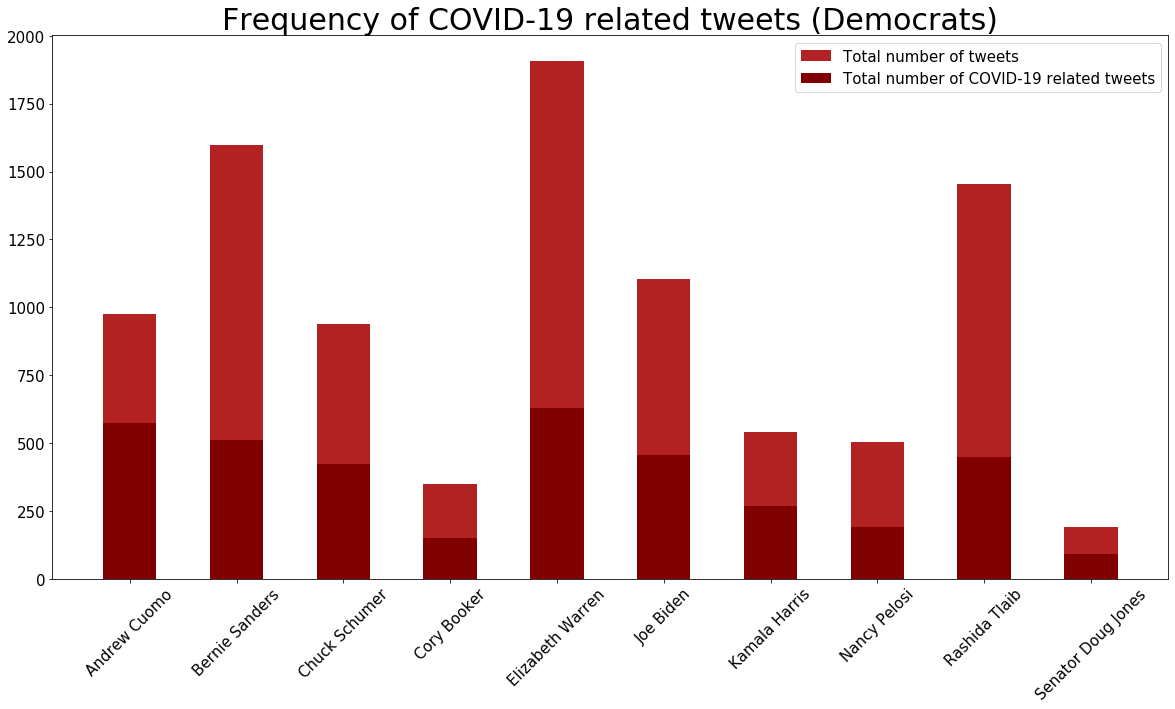

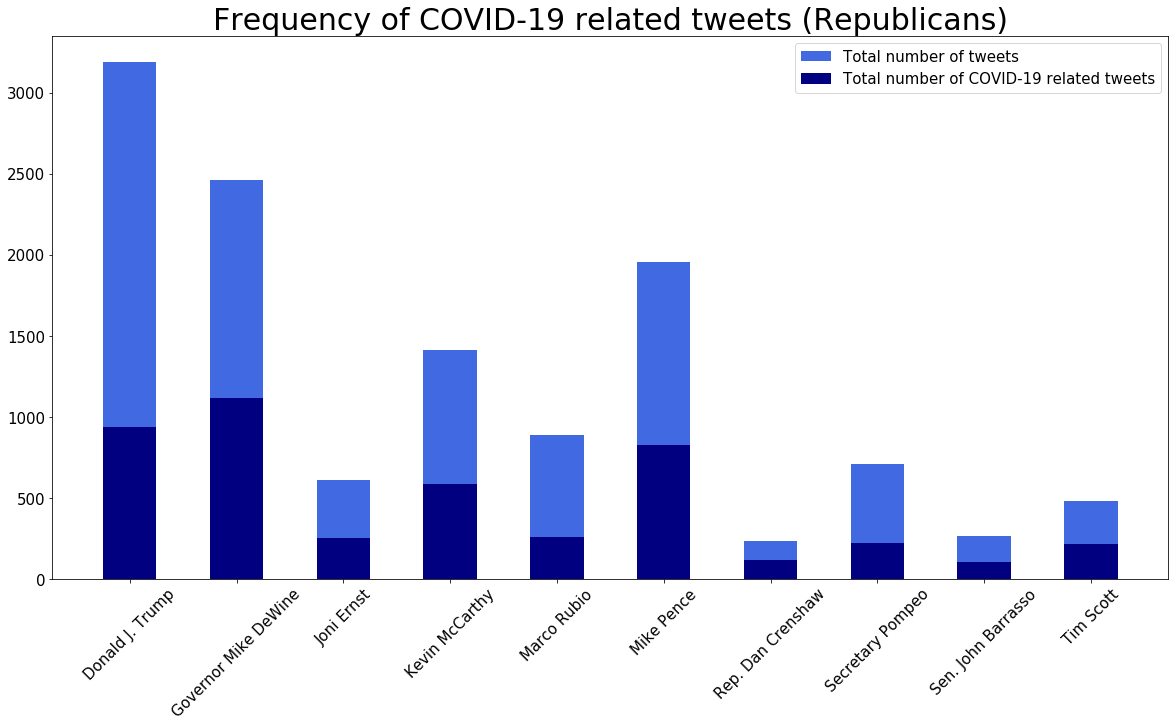

In [40]:
fig = plt.figure(figsize=(20,10))
name_size = 15
legend_size = 15
title_size = 30
for name,party,tweets_before,tweets_after in counts:
    if party == 'D':
        plt.bar(name, tweets_before, width=0.5, bottom=None, color='firebrick')
        plt.bar(name, tweets_after, width=0.5, bottom=None, color='maroon')
plt.xticks(rotation=45,fontsize=name_size)
plt.yticks(fontsize=name_size)
plt.title('Frequency of COVID-19 related tweets (Democrats)',fontsize=title_size)
plt.legend(['Total number of tweets','Total number of COVID-19 related tweets'],prop={'size': legend_size})

fig = plt.figure(figsize=(20,10))
for name,party,tweets_before,tweets_after in counts:
    if party == 'R':
        plt.bar(name, tweets_before, width=0.5, bottom=None, color='royalblue')
        plt.bar(name, tweets_after, width=0.5, bottom=None, color='navy')
plt.xticks(rotation=45,fontsize=name_size)
plt.yticks(fontsize=name_size)
plt.title('Frequency of COVID-19 related tweets (Republicans)',fontsize=title_size)
plt.legend(['Total number of tweets','Total number of COVID-19 related tweets'],prop={'size': legend_size});

In [45]:
current_week = datetime.datetime.now().isocalendar()[1]
current_week #the number of the week this year

18

Here we have written a function, which basically gives us a cumulative number of tweets for each week this year, provided a dataframe.

In [58]:
def cumulativeTweets(df):
    cumulative = np.array(np.zeros([1,current_week-1]))
    for index, tweet in df.iterrows():
        week = tweet.Created.week
        if week != current_week:
            cumulative[0][week-1] += 1
    return cumulative

We use this function to get the cumulative numbers for all tweets and also those concerning COVID-19.

In [59]:
cumulative_covid = cumulativeTweets(clean_df)
cumulative_overall = cumulativeTweets(df)
cumulative_covid, cumulative_overall

(array([[ 78., 193., 272., 235., 225., 291., 233., 257., 433., 532., 712.,
         923., 890., 841., 700., 657., 711.]]),
 array([[ 435.,  866., 1056., 1262., 1230., 1389., 1033., 1061., 1287.,
         1294., 1329., 1674., 1615., 1624., 1406., 1366., 1412.]]))

Here are the outputs visualized.

The following two graphs show how, like we wanted, the relevance and the importance of the issue has changed over time. The second one concisely shows a gradual growth in the concerns with the topic until at the end of the 10th week (beginning of March, when the first case of the virus was found in the United States) where the topic takes a majority of the proportion of the tweet content for the politicians, which it has continued to do so almost always ever since.

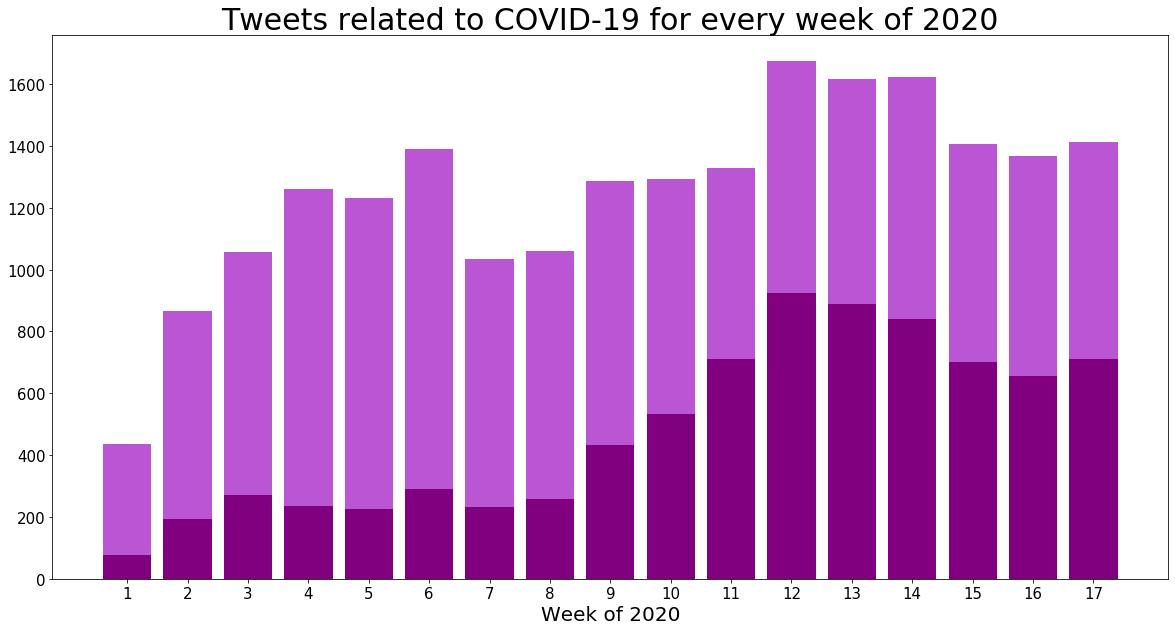

In [94]:
fig = plt.figure(figsize=(20,10))
nweeks = current_week
for week in range(1,nweeks):
    plt.bar(x=week,height=cumulative_overall[0][week-1],color='mediumorchid') 
    plt.bar(x=week,height=cumulative_covid[0][week-1],color='purple') 
plt.xticks(np.arange(1, nweeks, 1.0),fontsize=name_size);
plt.yticks(fontsize=name_size)
plt.xlabel('Week of 2020',fontsize=20)
plt.title('Tweets related to COVID-19 for every week of 2020',fontsize=title_size);

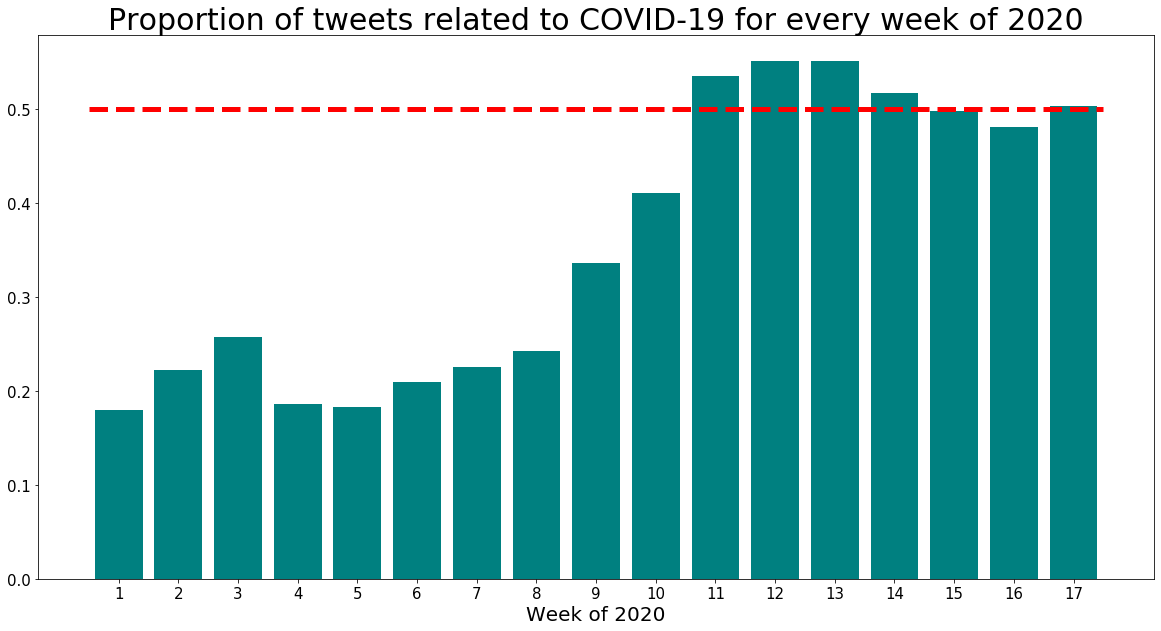

In [61]:
threshold = 0.5
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
nweeks = current_week
for week in range(1,nweeks):
    plt.bar(x=week,height=cumulative_covid[0][week-1]/cumulative_overall[0][week-1],color='teal')  
plt.xticks(np.arange(1, nweeks, 1.0),fontsize=name_size);
plt.yticks(fontsize=name_size)
plt.xlabel('Week of 2020',fontsize=20)
plt.title('Proportion of tweets related to COVID-19 for every week of 2020',fontsize=title_size)
ax.plot([0.5, 17.5], [threshold, threshold],"r--",linewidth=5);

### NLTK Sentiment Analysis
Below we have used VADER to perform sentiment analysis on our tweet dataset. Previously we had included graphs giving the sentiment scores for individual persons, but we decided that it was rather vague and ineffective in giving any key insight or providing contrast

In [62]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matthewpinho/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
sid = SentimentIntensityAnalyzer()

def sentiment(row):
    sent = sid.polarity_scores(row['Text'])
    row['pos'] = sent['pos']
    row['neg'] = sent['neg']
    row['neu'] = sent['neu']
    row['compound'] = sent['compound']
    return row

clean_df = clean_df.apply(lambda row: sentiment(row), axis=1)

In [71]:
clean_df.head()

,Name,Username,Party,Text,Created,Favorite Count,Retweet Count,Retweet,Media Attached,num_chars,word_count,pos,neg,neu,compound
4,Donald J. Trump,realDonaldTrump,R,BREAKING: Emails show Obama FBI was out to get...,2020-04-28 14:04:50,29153,13136,True,False,303,38,0.040,0.130,0.829,-0.5859
5,Donald J. Trump,realDonaldTrump,R,A fifth to half of all coronavirus deaths have...,2020-04-28 14:04:12,17626,7946,True,True,93,14,0.000,0.000,1.000,0.0000
6,Donald J. Trump,realDonaldTrump,R,Newly Declassified Documents Show John Kerry’s...,2020-04-28 13:58:55,39138,19718,True,True,121,13,0.000,0.000,1.000,0.0000
9,Donald J. Trump,realDonaldTrump,R,"45 days ago, business leaders joined President...",2020-04-28 13:53:21,24204,6536,True,False,271,38,0.181,0.053,0.766,0.6705
12,Donald J. Trump,realDonaldTrump,R,"We are doing far more, and better, Testing tha...",2020-04-28 12:06:03,170188,31268,False,False,270,52,0.282,0.046,0.672,0.9334


Similar to the function we wrote before, this function --for every week so far this year-- computes the cumulative positive, negative, and compound sentiments for tweets concerning the virus. We took care to normalize the cumulative sentiments by the total number of tweets themselves. So what is shown in the following graphs is actually the sentiment score per tweet. Also, these average sentiments are considered party-wise, which we compare for each type of sentiment.

In [80]:
def cumulativeSentiments(df,code):
    cumulative = np.array(np.zeros([1,current_week-1]))
    for index, tweet in df.iterrows():
        week = tweet.Created.week
        if week != current_week:
            cumulative[0][week-1] += tweet.loc[code]
    return cumulative/df.shape[0]

In [81]:
dems_df = clean_df.loc[clean_df.Party == 'D'] #dataframes specific to each party
reps_df = clean_df.loc[clean_df.Party == 'R']

In [82]:
dem_cumulative_neg = cumulativeSentiments(dems_df,'neg')
rep_cumulative_neg = cumulativeSentiments(reps_df,'neg')

Text(0.5, 0, 'Week of 2020')

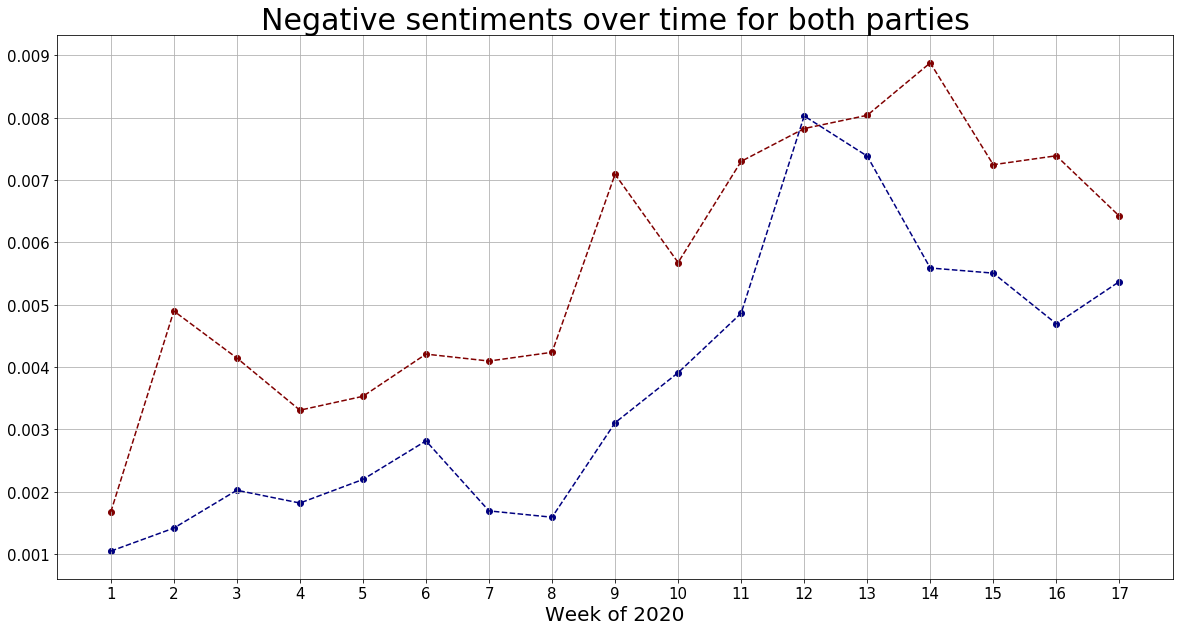

In [89]:
weeks= np.arange(1,nweeks)
fig = plt.figure(figsize=(20,10))
plt.plot(weeks,dem_cumulative_neg[0],color='maroon',linestyle='--')
plt.plot(weeks,rep_cumulative_neg[0],color='navy',linestyle='--')
plt.scatter(weeks,dem_cumulative_neg[0],color='maroon')
plt.scatter(weeks,rep_cumulative_neg[0],color='navy')
plt.title('Negative sentiments over time for both parties',fontsize=title_size)
plt.xticks(np.arange(1, nweeks, 1.0),fontsize=name_size);
plt.yticks(fontsize=name_size)
plt.grid()
plt.xlabel('Week of 2020',fontsize=20);

In [91]:
dem_cumulative_pos = cumulativeSentiments(dems_df,'pos')
rep_cumulative_pos = cumulativeSentiments(reps_df,'pos')

Text(0.5, 0, 'Week of 2020')

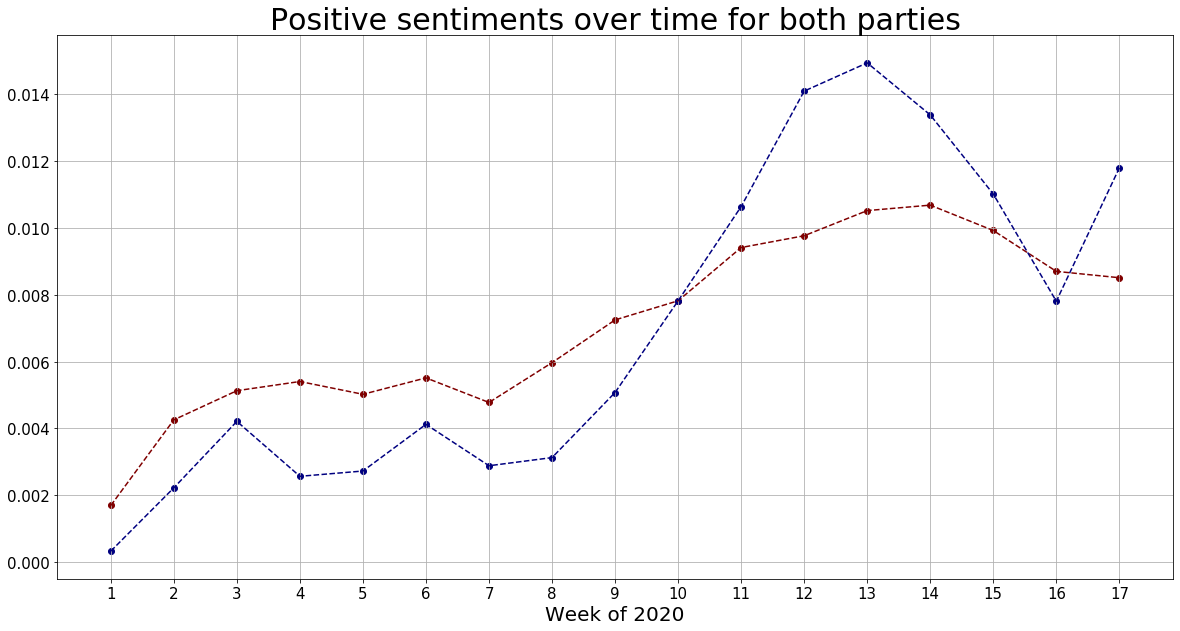

In [92]:
weeks= np.arange(1,nweeks)
fig = plt.figure(figsize=(20,10))
plt.plot(weeks,dem_cumulative_pos[0],color='maroon',linestyle='--')
plt.plot(weeks,rep_cumulative_pos[0],color='navy',linestyle='--')
plt.scatter(weeks,dem_cumulative_pos[0],color='maroon')
plt.scatter(weeks,rep_cumulative_pos[0],color='navy')
plt.title('Positive sentiments over time for both parties',fontsize=title_size)
plt.xticks(np.arange(1, nweeks, 1.0),fontsize=name_size);
plt.yticks(fontsize=name_size)
plt.grid()
plt.xlabel('Week of 2020',fontsize=20);

In [86]:
dem_cumulative_compound = cumulativeSentiments(dems_df,'compound')
rep_cumulative_compound = cumulativeSentiments(reps_df,'compound')

Text(0.5, 0, 'Week of 2020')

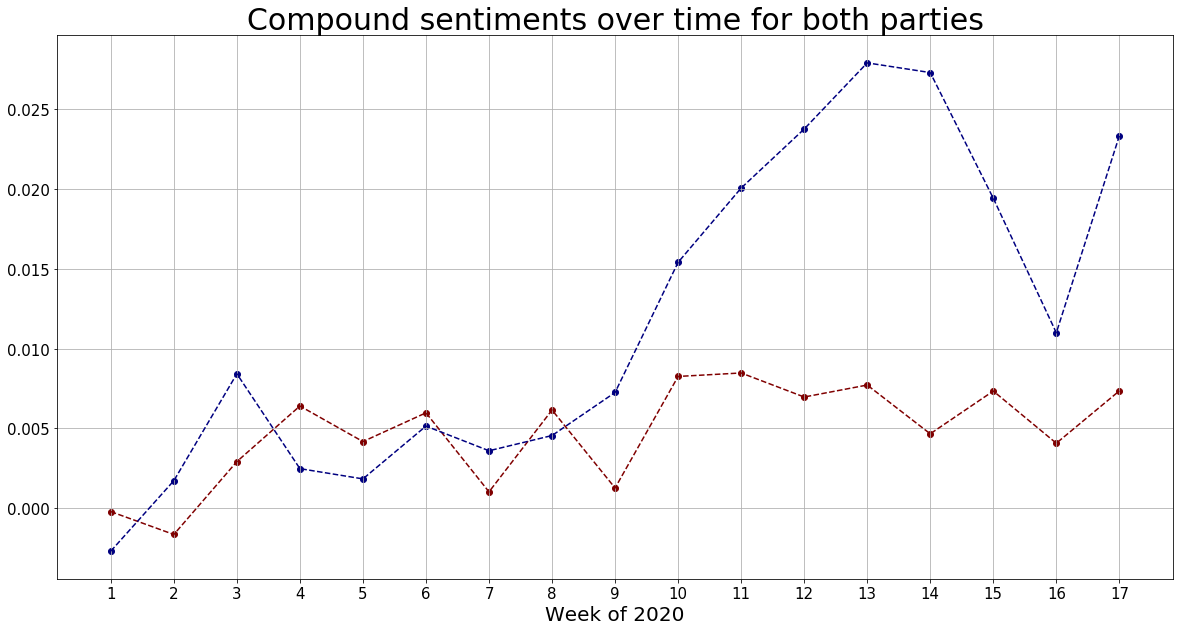

In [96]:
weeks= np.arange(1,nweeks)
fig = plt.figure(figsize=(20,10))
plt.plot(weeks,dem_cumulative_compound[0],color='maroon',linestyle='--')
plt.plot(weeks,rep_cumulative_compound[0],color='navy',linestyle='--')
plt.scatter(weeks,dem_cumulative_compound[0],color='maroon')
plt.scatter(weeks,rep_cumulative_compound[0],color='navy')
plt.title('Compound sentiments over time for both parties',fontsize=title_size)
plt.xticks(np.arange(1, nweeks, 1.0),fontsize=name_size);
plt.yticks(fontsize=name_size)
plt.grid()
plt.xlabel('Week of 2020',fontsize=20);

The above plots show that there is perhaps a key difference in the overall sentiments for each party regarding the pandemic. The first graph, of the negative sentiment scores over time, shows that there had been a gradual increase in the negative sentiment in both parties (until around week 12). For the majority of the time there is significantly a more negative sentiment associated with the Democrats as compare to Repubilcans.

On the plot displaying the scores for positive sentiment over time, Republicans have shown to be more positive towards the issue ever since week 10, when the first case was discovered in the US. But generally both parties seem to show a gradual increase in positive sentiment around the issue over time.

The third plot combines both the stories told in the previous two, which as we interpret, shows that both parties generally hold positive sentiments over the issue, with Republicans even more so than Democrats since the beginning of March.

### Limitations of Sentiment Analysis
Our initial thoughts were that sentiment analysis may yield some results that could help distinguish if people's thoughts regarding COVID-19 changed over time. We have begun looking at general trends present in the sentiment scores of each tweet and done basic visualizations. With these results, we are unsure if the sentiment scores alone may provide the insight into the data that we are interested in. With the graphs presented here, we do not see much variety in the sentiment scores. It appears that the sentiments may be slightly biased towards having compound sentiments.

Potential causes for this may be the VADER sentiment analysis algorithm itself in conjunction with the preprocessing done on the data. Using a bag of words approach, VADER may not be cognizant of many of the terms foudn in these tweets since the topic is so recent; the words may not be present in the bag used. Additionally, the preprocessing could hinder the results. Further work must be done in how we preprocess and clean the text. 

Sentiment analysis may also not show the results that we are looking for. Beyond improving our text cleaning and potentially the bag of words used, we will be exploring methods of using the sentiment scores in conjunction with other data pieces to perform different analyses.

# LDA 

Latent Dirichlet Allocation ([LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)) is a statistical model used to divide a dataset into groups. The model attempts to create these groups by placing similar pieces of data together. These groups may or may not be inherent within the dataset. Within machine learning, this approach could be classified as unsupervised learning because the model is discovering groups without being informed about the desired outcome. Instead, some metric is meant to be optimized.

When applied in natural language processing settings, LDA is most commenly used to extract topics from the various pieces of text provided. The idea is that the various pieces of text will be composed of numerous topics each signified through the words used in the text.

Applied here, we attempted to see if unique topics could be found within the COVID-19 related tweets that we gathered. To achieve this, we first cleaned and prepared the text for the model then analyzed the best number of topics, and finally trained and reviewed the results of our model. More details regarding each step can be found below.


__Some of the code in this section may appear as duplicate. This is intentional for now due to this being a unique effort from other forms of analysis that requires slightly different processes in the duplicated sections such s preprocessing and cleaning.__


## Setup/Imports

In [177]:
import pandas as pd
import nltk
import re
import gensim

from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

import pyLDAvis.gensim

try: 
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
except ImportError:
    pass

In [178]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data

In [5]:
DATA_FILE = './twenty_politicians.csv'
KEYWORDS_FILE = './covid_keywords.txt'

In [6]:
# Loading the tweets
df = pd.read_csv(DATA_FILE, index_col=0)
df['Created'] = pd.to_datetime(df['Created'])

print(df.shape)
df.head()

(20270, 8)


,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached
0,Donald J. Trump,realDonaldTrump,I will be having a White House Press Conferenc...,2020-04-24 20:51:16,24462,5259,False,False
1,Donald J. Trump,realDonaldTrump,https://t.co/x8Yguxf4Ks,2020-04-24 20:13:18,17264,3781,False,True
2,Donald J. Trump,realDonaldTrump,I will never let our Post Office fail. It has ...,2020-04-24 19:08:09,69032,13920,False,False
3,Donald J. Trump,realDonaldTrump,🚨 President Trump just signed the Paycheck Pro...,2020-04-24 17:02:47,0,5054,True,False
4,Donald J. Trump,realDonaldTrump,#BREAKING: President @RealDonaldTrump just sig...,2020-04-24 17:02:20,0,3843,True,False


In [7]:
# loading the keywords file
keywords = []

with open(KEYWORDS_FILE, 'r') as f:
    for line in f:
        keywords.append(re.escape(line.strip().lower()))
        
keywords[:5]

['unemployment', 'front\\ line', 'testing', 'health', 'public\\ health']

## Preprocessing tweets

The tweets are processed by first lowercasing all strings and only including those of which contains words or phrases present in the keywords (loaded above). During this step we also remove all non-alphanumeric characters, stopwords, and words with less than 3 letters. Additionally, words are also lemmatized meaning they are reduced to their root form. This allows for a more generalizable analysis.

Each entry is also divided into n-grams as well. N-grams are phrases of n words within the text. For this analysis, we used bi- and tri-grams, that is two and three word phrases. N-grams are used because in general, words gain meaning through context. By looking at groups of words, more meaningful text is usually extracted.

In [9]:
def part_of_speech(word):
    ''' Identifies the Part of Speech for given word '''
    pos = nltk.pos_tag([word])[0][1][0].upper()
    pos_dict = {
        'J' : wordnet.ADJ,
        'N' : wordnet.NOUN,
        'V' : wordnet.VERB,
        'R' : wordnet.ADV
    }
    
    return pos_dict.get(pos, wordnet.NOUN)

def clean_text(text, word_length=2, add_stopwords=None):
    ''' Cleans the given text '''
    
    # lowercased, only alpha-numeric, greater than word_length
    clean = text.lower()
    clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', clean).split()
    clean = [word for word in clean if len(word) > word_length]
    
    # lemmatize (convert to base word) w/ part of speech considered
    lemmatizer = WordNetLemmatizer()
    clean = [lemmatizer.lemmatize(word, part_of_speech(word)) for word in clean]
    
    # removing stop words in nltk's english stopwords plus additional
    stops = set(stopwords.words('english'))
    
    if add_stopwords:
        stops.add(add_words)
    
    clean = [word for word in clean if word not in stops]
    
    return clean

def ngrams_list(text, lower=1, upper=2):
    ngram_list = []
    for i in range(lower, upper):
        for ngram in ngrams(text, i):
            ngram_list.append(' '.join(str(word) for word in ngram))
            
    return ngram_list
    
    
def clean_tweets(tweet_df, keywords=None):
    ''' Cleans and processes all tweets in df, returns new df'''
    # copying the dataframe
    clean_df = tweet_df.copy()
    
    # converting everything to lowercase
    clean_df['Text'] = clean_df['Text'].str.lower()
    
    # Gathering only tweets with keywords if given
    if keywords:
        clean_df = clean_df[clean_df['Text'].str.contains('|'.join(keywords))]
    
    # Cleaning and tokenizing tweets
    clean_df['tokens'] = clean_df['Text'].apply(lambda x: clean_text(x))
    
    # removing rows without any tokens
    clean_df = clean_df[clean_df['tokens'].map(bool)]
    
    return clean_df

In [20]:
# Cleaning the tweets 
clean_df = clean_tweets(df, keywords=keywords)

# Getting all the bi- and tri-grams 
clean_df['ngrams'] = clean_df['tokens'].apply(lambda x: ngrams_list(x, 2, 3))

clean_df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached,tokens,ngrams
2,Donald J. Trump,realDonaldTrump,i will never let our post office fail. it has ...,2020-04-24 19:08:09,69032,13920,False,False,"[never, let, post, office, fail, mismanage, ye...","[never let, let post, post office, office fail..."
3,Donald J. Trump,realDonaldTrump,🚨 president trump just signed the paycheck pro...,2020-04-24 17:02:47,0,5054,True,False,"[president, trump, sign, paycheck, protection,...","[president trump, trump sign, sign paycheck, p..."
4,Donald J. Trump,realDonaldTrump,#breaking: president @realdonaldtrump just sig...,2020-04-24 17:02:20,0,3843,True,False,"[break, president, realdonaldtrump, sign, legi...","[break president, president realdonaldtrump, r..."
5,Donald J. Trump,realDonaldTrump,✓ signed\n\npresident @realdonaldtrump just si...,2020-04-24 17:02:05,0,3627,True,False,"[sign, president, realdonaldtrump, sign, phase...","[sign president, president realdonaldtrump, re..."
6,Donald J. Trump,realDonaldTrump,great conversation with president lenin moreno...,2020-04-24 14:59:34,55045,12152,False,False,"[great, conversation, president, lenin, moreno...","[great conversation, conversation president, p..."


## Training LDA

Within this section, we train the LDA model by first performing multiple small models in order to find the best configuration. Based on this, we then perform a more in depth training with the chosen settings.

Below are parameters used throughout the remainder of the notebook. `RANDOM_STATE` seeds the random aspect of the model allowing for reproducible results.

In [11]:
# Parameters
RANDOM_STATE = 23

In [21]:
# Creating a dictionary mapping word -> id
dictionary = gensim.corpora.Dictionary(clean_df['ngrams'])

# removes tokens that appear in less than 10 documents or over 50%
dictionary.filter_extremes(no_below=10, no_above=0.5)

doc_bags = [dictionary.doc2bow(x) for x in clean_df['ngrams']]

tfidf = gensim.models.TfidfModel(doc_bags)
corpus = tfidf[doc_bags]

In [90]:
def eval_lda(corpus, dictionary, texts, num_topics, alpha, beta):
    ''' Used to evaluate an LDA model trained with the given input values based on coherence score '''
    lda_model = gensim.models.ldamulticore.LdaMulticore(
                                     corpus=corpus, 
                                     num_topics=num_topics, 
                                     id2word=dictionary, 
                                     passes=10, 
                                     alpha=alpha,
                                     eta=beta,
                                     random_state=RANDOM_STATE)
    
    perp = lda_model.log_perplexity(corpus)
    cm_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='c_v')
    coh = cm_lda.get_coherence()
    print(f'Topics: {num_topics}, alpha: {alpha}, beta: {beta}, perplexity: {perp}, coherence: {coh}')
    return perp, coh

Below we train a range of LDA models testing the desired settings. For each model, the log perplexity and coherence scores are recorded. The scores resemble different aspects about regarding the text, but a lower perplexity is better. The higher the coherence, the better. Some studies believe that perplexity does not necessarily align with the 'human-interpretability' of the text. Coherence is believed to be preferred for this.

We chose to prioritize coherence in our decision. With our training models, we only varied the number of topics for now. In the future, we may experiment with more settings. The graph below shows that coherence seems to plateau at 15 topics, so we continued with 15 topics.

In [92]:
min_topics = 2
max_topics = 40
alphas = [0.001]    # document-topic density: topics contained within documents
betas = ['auto']                   # word-topic density: how many words from dictionary are contained within each topic

results = []

for k in range(min_topics, max_topics + 1):
    for alpha in alphas:
        for beta in betas:
            perp, coh = eval_lda(corpus, dictionary, clean_df['ngrams'].values, k, alpha, beta)
            results.append((k, alpha, beta, perp, coh))

Topics: 2, alpha: 0.001, beta: auto, perplexity: -7.002110655009065, coherence: 0.5032810123224813
Topics: 3, alpha: 0.001, beta: auto, perplexity: -7.203118819746741, coherence: 0.5376369423754247
Topics: 4, alpha: 0.001, beta: auto, perplexity: -7.385144948820041, coherence: 0.5712802005258477
Topics: 5, alpha: 0.001, beta: auto, perplexity: -7.541038031658946, coherence: 0.5395776717334028
Topics: 6, alpha: 0.001, beta: auto, perplexity: -7.680852862839065, coherence: 0.5655571750106626
Topics: 7, alpha: 0.001, beta: auto, perplexity: -7.817272292771904, coherence: 0.5764476654748132
Topics: 8, alpha: 0.001, beta: auto, perplexity: -7.939967127228186, coherence: 0.5688178671678881
Topics: 9, alpha: 0.001, beta: auto, perplexity: -8.058205412104945, coherence: 0.5865043643458558
Topics: 10, alpha: 0.001, beta: auto, perplexity: -8.186362064326074, coherence: 0.599482377007451
Topics: 11, alpha: 0.001, beta: auto, perplexity: -8.285204777085179, coherence: 0.5915623869294862
Topics: 1

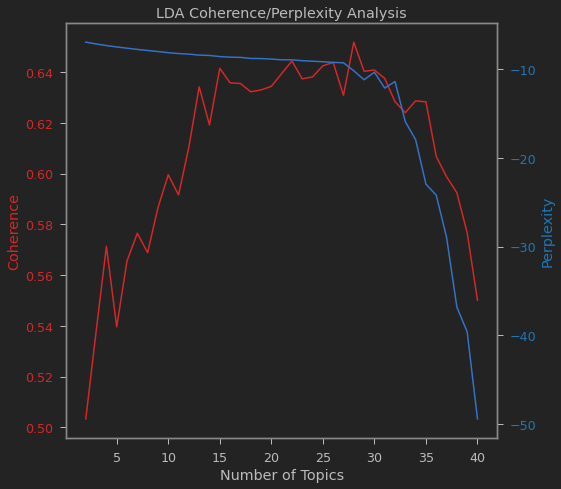

In [175]:
fig, ax1 = plt.subplots()

c1 = 'tab:red'
c2 = 'tab:blue'

ax1.set_title('LDA Coherence/Perplexity Analysis')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=c1)
ax1.plot([i[0] for i in results], [i[4] for i in results], color=c1)
ax1.tick_params(axis='y', labelcolor=c1)

ax2 = ax1.twinx()
ax2.set_ylabel('Perplexity', color=c2)
ax2.plot([i[0] for i in results],[i[3] for i in results])
ax2.tick_params(axis='y', labelcolor=c2)

fig.tight_layout()
plt.show()

In [100]:
NUM_TOPICS = 15
NUM_PASSES = 100
ALPHA = 0.001
BETA = 'auto'

lda_model = gensim.models.ldamodel.LdaModel(
                                     corpus=corpus, 
                                     num_topics=NUM_TOPICS, 
                                     id2word=dictionary, 
                                     passes=NUM_PASSES, 
                                     alpha=ALPHA,
                                     eta=BETA,
                                     random_state=RANDOM_STATE)

perp = lda_model.log_perplexity(corpus)
coh = gensim.models.CoherenceModel(model=lda_model, texts=clean_df['ngrams'].values, corpus=corpus, coherence='c_v').get_coherence()
print(f'Trained Model Statistics:\n\tCoherence: {coh}\n\tPerplexity: {perp}')

Trained Model Statistics:
	Coherence: 0.657353913873379
	Perplexity: -15.029024011821553


## Analyzing LDA 

### Visualizing LDA

The LDA model can be visualized through the python module `pyLDAvis` which provides this nice interactive graphic. The graphic depicts the topics mapped to two principal components. Hovering over a topic shows the most frequent terms within that topic as well as how frequent the term is throughout all the texts. 

Looking at the topics, none overlap, and they appear to be evenly spaced. This suggests that each topic is about something distinct within the text.

In [101]:
lda_data =  pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(lda_data)

### Topic Analysis

A cursorary study of the topics was done by first analyzing the five most relative words for each topic. The horizontal bar graphs below show the word as well as the weight it provides to that topic. Looking at these words, some topics seem to have separate themes, but there are others that may not be very well defined from one another as it appeared above. This lack of distinction could be due to how narrow the topic is being COVID-19. We still expected to see further separation with unique topics about the pandemic. With further analysis, we may find those.

The next analyis we performed was finding the most representative tweet for each topic. This was done by first using the model to classify each tweet to its dominant topic. This included the probability that the tweet would belong to that topic. We took the tweet with the greatest probability to be the most representative of that topic. In the printed out portion, we list the size of the topic, the tweet's author, the tweet's probability, and the tweet's text. 

Reading through the tweets, there appear to be connections between the most important words listed in the graphs, and the most representative tweet for a given topic. We plan to associate the topics with their most important words combining the two different analysis done here, but at this time we couldn't find a way to garuntee we were connecting the correct two.

Considering the sizes, disregarding one topic that is significantly larger than the rest, the topics all float around the same sizes showing a fairly even distribution between the topics.

Going forward with our analysis, we would like to consider the author's party in our analysis. Do the topics contain more activity from one party? Are there topics that only one party partakes in? 

In [146]:
def hor_bars(data, ax):
    labels, vals = zip(*data)
    
    y_vals = np.arange(len(labels))
    
    labels = [x for x in labels]
    labels = [''] + labels
    
    ax.barh(y_vals, vals)
    ax.set_yticklabels(labels)
    ax.set_xlim(0, 0.1)
    ax.invert_yaxis()

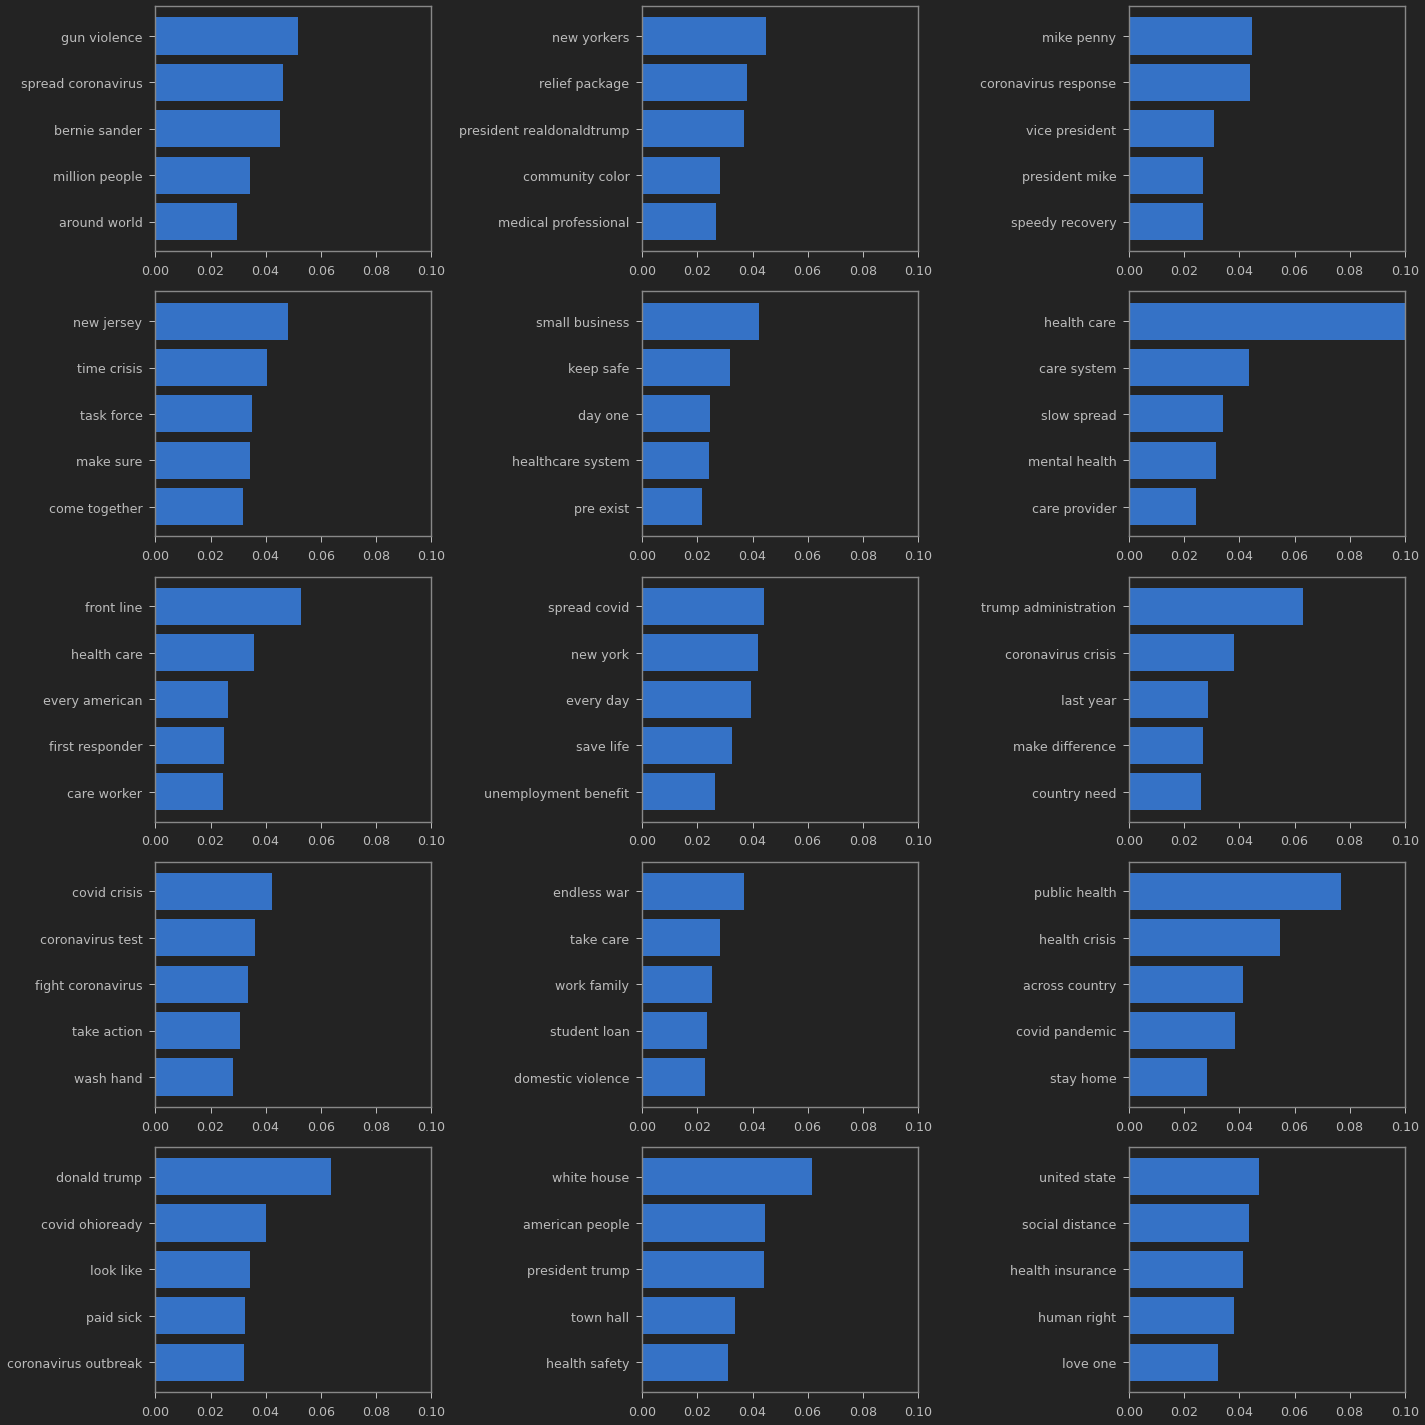

In [147]:
topics_weights = lda_model.show_topics(num_topics=NUM_TOPICS, num_words=5, formatted=False)

fig, axs = plt.subplots(5, 3, figsize=(20, 20))
axs = axs.flatten()

for topic in topics_weights:
    hor_bars(topic[1], axs[topic[0]])

plt.tight_layout()
plt.show()

In [152]:
def dominant_topic(row, model, dictionary):
    weights = model.get_document_topics(dictionary.doc2bow(row['ngrams']))
    dom_topic, dom_prob = max(weights, key=lambda x: x[1])
    row['dom_topic'] = dom_topic
    row['dom_prob'] = dom_prob
    
    return row

clean_df['dom_topic'] = -1
clean_df['dom_prob'] = -1

clean_df = clean_df.apply(lambda row: dominant_topic(row, lda_model, dictionary), axis=1)

In [176]:
dom_grps = clean_df.groupby('dom_topic')

for i, grp in dom_grps:
    best_text = grp['dom_prob'].sort_values(ascending=False).index[0]
    row = grp.loc[best_text]
    print('Topic:', i)
    print('Size:', grp.shape[0])
    print(f'\tUser w/ Most Representative Tweet: {row["Name"]}')
    print(f'Dominant probability: {row["dom_prob"]}')
    print(f'Text: {row["Text"]}')
    print()

Topic: 0
Size: 1515
	User w/ Most Representative Tweet: Elizabeth Warren
Dominant probability: 0.9972083568572998
Text: we need to treat gun violence like a public health emergency. that means we collect data about where the threats come from, and then reduce those threats. we have to be a nation committed to reducing gun violence. as president, i will reduce gun violence by 80% over eight years.

Topic: 1
Size: 491
	User w/ Most Representative Tweet: Elizabeth Warren
Dominant probability: 0.9980042576789856
Text: we need to provide immediate and comprehensive relief to consumers in the next coronavirus relief package. @sherrodbrown and i have a plan to stop banks from snatching stimulus checks, pause payments, prevent credit damage, cancel student debt, and more.  https://t.co/9io3mheldn

Topic: 2
Size: 399
	User w/ Most Representative Tweet: Governor Mike DeWine
Dominant probability: 0.999300479888916
Text: updated #covid19 data just posted to https://t.co/3lwx4irscb 

note: because 

### t-SNE Visualization

t-SNE provides a way of probabilistically performing dimensionality reduction. When applied correctly, it is very powerful and very interesting features can be found.

We attempted to reduce the dimensions down to two and three components so we could visualize it while also coloring each tweet based on the topic it belonged to. We would also like to color each tweet based on the author's political party.

Our attempts at applying t-SNE so far have not been completely successful. While our loss function (KL Divergence) appears to be reducing, the visualizations appear busy or meaningless. This could be due to an error on our part or that the data simply does not have defined topics like we believed. We will continue to look into this for future analysis.

In [109]:
weights = []
for i, row_list in enumerate(lda_model[corpus]):
    weights.append([w[1] for w in row_list])
    
tsne_arr = pd.DataFrame(weights).fillna(0).values

topic_colors = np.argmax(tsne_arr, axis=1)

col = np.array(['r', 'b', 'g', 'y', 'w'])

In [110]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, perplexity=50, n_iter=10000, n_jobs=5)
tsne_lda = tsne.fit_transform(tsne_arr)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8340 samples in 0.016s...
[t-SNE] Computed neighbors for 8340 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8340
[t-SNE] Computed conditional probabilities for sample 2000 / 8340
[t-SNE] Computed conditional probabilities for sample 3000 / 8340
[t-SNE] Computed conditional probabilities for sample 4000 / 8340
[t-SNE] Computed conditional probabilities for sample 5000 / 8340
[t-SNE] Computed conditional probabilities for sample 6000 / 8340
[t-SNE] Computed conditional probabilities for sample 7000 / 8340
[t-SNE] Computed conditional probabilities for sample 8000 / 8340
[t-SNE] Computed conditional probabilities for sample 8340 / 8340
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.685707
[t-SNE] KL divergence after 10000 iterations: 0.267257


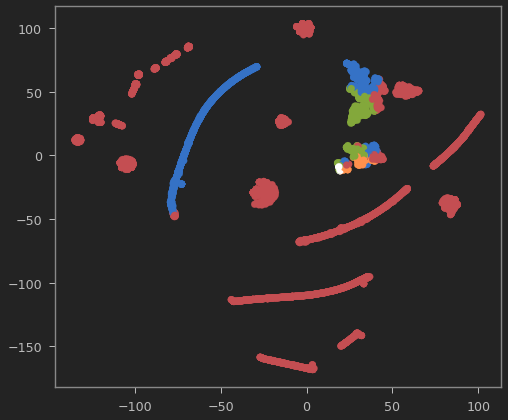

In [111]:
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], c=topic_colors, cmap=matplotlib.colors.ListedColormap(col))

# Contributions
Emily Lawson: Setting up the report: topic introduction, hypotheses, conclusions

Justin Deutsch: Code and explanations for data preprocessing/filtering, sentiment analysis, LDA, visualizations, conclusions

Matthew Pinho: Code and explanations for data collection, writing filter keywords for preprocessing/filtering, visualizations, finalizing report